---
title: "2A. Reporte escrito. Experimentos y análisis de estructuras de datos."
subtitle: "Análisis de Algoritmos 2025-2"
author: "Mendiola Alavéz Dalia Isabel"
format:
  pdf:
    documentclass: article
    fontsize: 12pt
    geometry: margin=1in
    code-overflow: wrap
    output-width: 0.9\textwidth
    include-in-header:
      text: |
        \usepackage{fancyhdr}
        \pagestyle{fancy}
        \fancyhead[L]{Mendiola Alavéz Dalia Isabel}
        \fancyhead[R]{Análisis de Algoritmos 2025-2}
        \fancyfoot[C]{\thepage}
        \usepackage[htt]{hyphenat}
---

**Introducción**

El análisis y procesamiento de datos en dimensiones altas requiere técnicas eficientes tanto en tiempo de cómputo como en uso de memoria. Una operación fundamental en este contexto es el producto punto entre vectores, que constituye la base de numerosos algoritmos en aprendizaje automático, recuperación de información y análisis de datos multivariantes. Tradicionalmente, este cálculo se puede realizar mediante bucles explícitos, como en la función getmaxdot, que recorre todas las columnas de una matriz comparando cada producto punto (Malkov & Yashunin, 2020). Sin embargo, este enfoque resulta ineficiente cuando se manejan grandes volúmenes de datos.

Para mejorar el rendimiento, se emplean técnicas vectorizadas, que aprovechan operaciones matriciales optimizadas en librerías como NumPy o frameworks basados en BLAS/CUBLAS (Torres et.al., 2024). Estas versiones permiten calcular simultáneamente todos los productos punto, reduciendo drásticamente el tiempo de ejecución. Además, cuando los tamaños de las matrices exceden la capacidad de memoria, se pueden implementar procesamientos por bloques, que dividen los datos en segmentos manejables, minimizando el uso de memoria sin sacrificar precisión.

En el contexto de estructuras de datos, el uso de estructuras elementales como arreglos, matrices y listas proporciona la base sobre la cual se construyen índices más sofisticados, como árboles de búsqueda, k-d trees o grafos HNSW, que permiten realizar búsquedas y comparaciones de vectores de manera eficiente sin tener que recorrer todos los elementos (Samet, 2006; Malkov & Yashunin, 2020). La correcta elección y manejo de estas estructuras es crucial para diseñar algoritmos escalables y optimizados, especialmente en aplicaciones de alto rendimiento o en análisis de grandes volúmenes de datos.

En este reporte se presentan y comparan diferentes enfoques para calcular el producto punto máximo entre vectores, evaluando tanto la eficiencia computacional como la memoria utilizada. Se implementan versiones clásicas, vectorizadas y por bloques, ilustrando cómo las decisiones sobre estructuras de datos y paralelización afectan directamente el rendimiento de los algoritmos.




In [15]:
# Comenzamos importando las librerías a utilizar:

# Para crear gráficos y visualizaciones:
import matplotlib.pyplot as plt
# Para operaciones numéricas eficientes, especialmente con arrays:
import numpy as np
# Para manejar y analizar datos en estructuras tipo DataFrame:
import pandas as pd
# Para medir tiempos de ejecución o hacer pausas:
import time
# Para interactuar con el sistema (manejo de rutas y argumentos):
import sys

**Implementa los siguientes algoritmos:**

  - **Dado la matriz Q de tamaño $d \times m$ y la matriz $X$ de tamaño $d \times n$, para cada vector columna de $q \in Q$ encontrar el vector columna de $x \in X$ que maximiza su producto punto. Dicho de otra forma, el problema consiste en asociar cada $q$ con $\text{argmax}{q \cdot x ∣ x \in X}$. Este será el problema de encontrar el producto punto máximo o top-1.**

In [16]:
# Se define la función 'mydot' para calcular el producto punto entre dos
# vectores:

# Calcula el producto punto entre dos vectores 1D.
# Parámetros:
# u : array-like de dimensión (d,)
# x : array-like de dimensión (d,)
# Retorna s : El valor del producto punto u · x

def mydot(u, x):
  s = 0.0
  for ui, xi in zip(u, x):
    s += ui * xi
  return s

# Se define la función 'getmaxdot' para encontrar el vector columna en una matriz
# que produce el máximo producto punto con un vector dado

# Se define la función 'getmaxdot' donde:
# u: es el vector columna (d,)
# X: es la matriz de tamaño (d, n)
# Regresa (índice, valor) del máximo producto punto

def getmaxdot(u,X):
  maxpos = 0
  maxdot = mydot(u, X[:, 0])

  _, ncols = X.shape
  for i in range(1, ncols):
    d = mydot(u, X[:, i])
    if d > maxdot:
      maxpos = i
      maxdot = d
  return maxpos, maxdot



In [17]:
# Ejemplo de prueba de las funciones definidas

# Creamos un vector 'u' de tamaño 4 con valores aleatorios entre 0 y 1
u = np.random.rand(4)

# Creamos una matriz 'X' de tamaño 4x1000 con valores aleatorios entre 0 y 1
# Cada columna representa un vector con el que compararemos 'u'
X = np.random.rand(4, 1000)

# Usamos la función 'getmaxdot' para encontrar la columna de X que tiene
# el producto punto máximo con el vector u
idx, val = getmaxdot(u, X)

# Mostramos el índice de la columna con el producto punto máximo y su valor
print(f"Mejor índice: {idx}, Valor del producto punto: {val}")

Mejor índice: 991, Valor del producto punto: 1.6486541749755446


**Comparación de desempeños**

  - **Considere un conjunto de datos como una tupla $Q$, $X$.**
  - **Genere 9 conjuntos de datos para las 9 combinaciones de $m$ y $n$; i.e., $m \in {10^3,10^4,10^5}$ y $n \in {10^3,10^4,10^5}$.**
  - **Genere cada matriz $Q$ o $X$ para que contenga vectores columna aleatorios de la esfera unitaria de dimensión $d=8$. Se recomienda realizar este paso generando matrices aleatorias y después poner cada columna a norma 1.**
  - **Resuelva el problema top-1 con los dos algoritmos para cada conjunto de datos, contando el número de operaciones (sumas y productos), el tiempo real, y la memoria necesaria para cada algoritmo en cada problema.**

Primero generamos los datos en la esfera unitaria:

In [18]:
# Se genera una matriz (d,n) con vectores columna en la esfera unitaria

# Parámetros:
# d : Dimensión de cada vector
# n : Número de vectores columna
# dtype : Tipo de datos de la matriz generada
# Retorna:
# M : Matriz con columnas normalizadas a longitud 1

def generate_unit_sphere_matrix(d, n, dtype=np.float32):
  # Matriz normal (0, 1)
  M = np.random.randn(d, n).astype(dtype)
  # Normalizamos las columnas
  M /= np.linalg.norm(M, axis=0, keepdims=True)
  return M


Establecemos los algoritmos:

In [19]:
# Generación del algoritmo en versión vectorizada con producto matricial

# Encuentra, para cada vector columna en Q, la columna de X que tiene
# el producto punto máximo, utilizando operaciones vectorizadas para eficiencia
# Parámetros: Q - Matriz cuyas columnas son los vectores de consulta.
# X - Matriz cuyas columnas se comparan con cada columna de Q.
# Retorna: max_indices : indices de las columnas de X que producen el producto
# punto máximo para cada vector columna de Q.

def top_maxdot(Q, X):
  # Q.T @ X produce una matriz de tamaño (m, n) donde cada elemento (i,j)
  # es el producto punto entre la columna i de Q y la columna j de X
  dot_products = Q.T @ X
  max_indices = np.argmax(dot_products, axis=1)
  return max_indices

In [20]:
# Generación del algoritmo en versión 'getmaxdot'

# Se retoma la versión vectorizada para encontrar el índice de la columna con
# producto punto máximo
def top1_maxdot(Q, X):
    # Algoritmo vectorizado con producto matricial:
    dot_products = Q.T @ X
    max_indices = np.argmax(dot_products, axis=1)
    return max_indices

# Establecemos una versión por bloques para manejar matrices muy grandes y
# ahorrar memoria

# Parámetros: Q - vectores de consulta. X - Matriz a comparar
# block_size : Tamaño de cada bloque de columnas de X para procesamiento
# Retorna: best_idx - índices de las columnas de X con producto punto máximo
def top1_maxdot_blocked(Q, X, block_size=5000):
    m = Q.shape[1]
    n = X.shape[1]
    best_idx = np.zeros(m, dtype=int)
    best_val = np.full(m, -np.inf, dtype=np.float32)

    # Procesamos X en bloques
    for start in range(0, n, block_size):
      end = min(start + block_size, n)
      dots = Q.T @ X[:, start:end]
      local_idx = np.argmax(dots, axis=1)
      local_val = np.max(dots, axis=1)

      # Actualizamos solo donde encontramos un valor mayor al anterior
      mask = local_val > best_val
      best_val[mask] = local_val[mask]
      best_idx[mask] = start + local_idx[mask]

    return best_idx

# Se define la función que calcula el producto punto entre dos vectores 1D
def mydot(u, x):
  s = 0.0
  for ui, xi in zip(u, x):
    s += ui * xi
  return s

# Se calcula el índice de la columna de X con producto punto máximo con u
# usando bucles
def getmaxdot(u, X):
  maxpos = 0
  maxdot = mydot(u, X[:, 0])
  _, ncols = X.shape
  for i in range(1, ncols):
    d = mydot(u, X[:, i])
    if d > maxdot:
      maxpos = i
      maxdot = d
  return maxpos

# Se calculan los índices de columna con producto punto máximo para cada vector
# columna de Q usando la getmaxdot
# Retorna: ndarray de índices máximos por columna de Q
def getmaxdot_for_Q(Q, X):
  results = []
  for j in range(Q.shape[1]):
    results.append(getmaxdot(Q[:, j], X))
  return np.array(results)

Se definen las métricas:

Operaciones aritméticas $(\Sigma \text{ y } x)$:

- Para cada producto punto: $2d$ operaciones ($d$ multiplicaciones + $d$ sumas).

- En el algoritmo getmaxdot: $m \cdot n \cdot (2d)$ operaciones.

- En la versión vectorizada: el producto matricial Q.T @ X requiere $≈ 2 \cdot m \cdot n \cdot d$ operaciones.

Memoria:

- Aproximamos con Q.nbytes + X.nbytes

In [21]:
# Función que compara el rendimiento de diferentes métodos para encontrar la
# columna de X que produce el producto punto máximo para cada columna de Q
# Parámetros: Q - Matriz de vectores de consulta, X - Matriz de vectores a
# comparar .
# Método a usar: "vectorized" o "getmaxdot"

def comparison(Q, X, method="vectorized", block_threshold=2e8):
  d, m = Q.shape
  _, n = X.shape

  if method == "vectorized":
    # Si el tamaño del problema supera el umbral, usamos la versión por bloques:
    if m * n > block_threshold:
      start = time.time()
      result = top1_maxdot_blocked(Q, X)
      elapsed = time.time() - start
    else:
      start = time.time()
      result = top1_maxdot(Q,X)
      elapsed = time.time() - start
    ops = 2 * m * n * d
  else:
      # Método'getmaxdot' usando bucles
      start = time.time()
      result = getmaxdot_for_Q(Q, X)
      elapsed = time.time() - start
      ops = 2 * m * n * d

  # Estimación de memoria utilizada por las matrices Q y X (en bytes)
  memory = Q.nbytes + X.nbytes

  return {
      "method": method,
      "m": m,
      "n": n,
      "ops": ops,
      "time_sec": elapsed,
      "memory_MB": memory / (1024**2)
  }

Se ejecuta el experimento con 9 combinaciones:

In [22]:
# Experimentos para comparar rendimiento de los métodos

# Dimensión de los vectores:
d = 8
# Diferentes tamaños de conjuntos de consulta Q
m_values = [10**3, 10**4, 10**5]
# Diferentes tamaños de conjuntos de vectores X
n_values = [10**3, 10**4, 10**5]

results = []

for m in m_values:
  for n in n_values:
    print(f"Caso m={m}, n={n}")
    Q = generate_unit_sphere_matrix(d, m)
    X = generate_unit_sphere_matrix(d, n)

    # Método vectorizado
    res_vec = comparison(Q, X, method="vectorized")
    results.append(res_vec)
    print("Método vectorizado:", res_vec)

    # Método 'getmaxdot' (se establece el límite a 10^4 para hacer eficiente la
    # comparación)
    if m <= 1e4 and n <= 1e4:
      res_get = comparison(Q, X, method="getmaxdot")
      results.append(res_get)
      print("Método getmaxdot:", res_get)


Caso m=1000, n=1000
Método vectorizado: {'method': 'vectorized', 'm': 1000, 'n': 1000, 'ops': 16000000, 'time_sec': 0.006758451461791992, 'memory_MB': 0.06103515625}
Método getmaxdot: {'method': 'getmaxdot', 'm': 1000, 'n': 1000, 'ops': 16000000, 'time_sec': 5.321566820144653, 'memory_MB': 0.06103515625}
Caso m=1000, n=10000
Método vectorizado: {'method': 'vectorized', 'm': 1000, 'n': 10000, 'ops': 160000000, 'time_sec': 0.04374432563781738, 'memory_MB': 0.335693359375}
Método getmaxdot: {'method': 'getmaxdot', 'm': 1000, 'n': 10000, 'ops': 160000000, 'time_sec': 42.50253486633301, 'memory_MB': 0.335693359375}
Caso m=1000, n=100000
Método vectorizado: {'method': 'vectorized', 'm': 1000, 'n': 100000, 'ops': 1600000000, 'time_sec': 0.3472719192504883, 'memory_MB': 3.082275390625}
Caso m=10000, n=1000
Método vectorizado: {'method': 'vectorized', 'm': 10000, 'n': 1000, 'ops': 160000000, 'time_sec': 0.029251575469970703, 'memory_MB': 0.335693359375}
Método getmaxdot: {'method': 'getmaxdot',

In [23]:
# Guardamos los resultados en un DataFrame
df = pd.DataFrame(results)
df["problem_size"] = df["m"] * df["n"]
df["ops_per_sec"] = df["ops"] / df["time_sec"]

print("Resultados Finales:")
print(df)

Resultados Finales:
        method       m       n           ops    time_sec  memory_MB  \
0   vectorized    1000    1000      16000000    0.006758   0.061035   
1    getmaxdot    1000    1000      16000000    5.321567   0.061035   
2   vectorized    1000   10000     160000000    0.043744   0.335693   
3    getmaxdot    1000   10000     160000000   42.502535   0.335693   
4   vectorized    1000  100000    1600000000    0.347272   3.082275   
5   vectorized   10000    1000     160000000    0.029252   0.335693   
6    getmaxdot   10000    1000     160000000   41.939898   0.335693   
7   vectorized   10000   10000    1600000000    0.248410   0.610352   
8    getmaxdot   10000   10000    1600000000  416.490127   0.610352   
9   vectorized   10000  100000   16000000000    3.088744   3.356934   
10  vectorized  100000    1000    1600000000    0.248428   3.082275   
11  vectorized  100000   10000   16000000000    4.357578   3.356934   
12  vectorized  100000  100000  160000000000   29.754771 

Se realizan las gráficas comparativas:

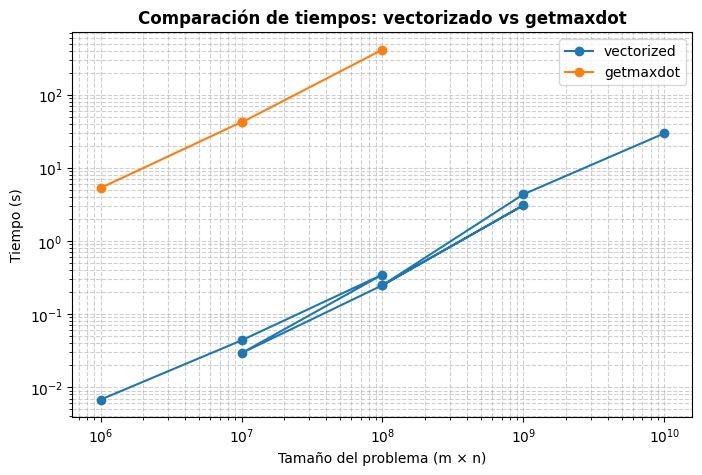

In [24]:
# Tiempo
plt.figure(figsize=(8,5))
for method in df["method"].unique():
    subset = df[df["method"] == method]
    plt.plot(subset["problem_size"], subset["time_sec"], marker="o",
             label=method)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Tamaño del problema (m × n)")
plt.ylabel("Tiempo (s)")
plt.title("Comparación de tiempos: vectorizado vs getmaxdot", fontweight='bold')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.show()


**Discusión de la gráfica: "Comparación de tiempos: vectorizado vs getmaxdot"**

La gráfica muestra cómo varía el tiempo de ejecución en función del tamaño del problema $(m \times n)$, comparando los métodos vectorizado y getmaxdot:

- *Crecimiento del tiempo en $getmaxdot$*: Se observa que la curva naranja ($getmaxdot$) crece de manera casi lineal en la escala log-log. Esto es consistente con la complejidad del algoritmo: cada producto escalar se calcula de forma explícita y sin aprovechamiento de operaciones vectorizadas. En consecuencia, el tiempo aumenta rápidamente con el tamaño del problema, llegando a ser de cientos de segundos en los casos grandes.

- *Comportamiento del método $vectorizado$*: La curva azul ($vectorizado$) se mantiene mucho más baja que la de $getmaxdot$ en todos los tamaños de problema. Para problemas pequeños $(10^6 \leq m \times n \leq 10^7)$, el tiempo es del orden de milisegundos, mostrando la gran ventaja de aprovechar las operaciones de álgebra lineal optimizadas en NumPy. A partir de tamaños intermedios $(10^8 – 10^9)$, la curva crece, pero de manera más controlada que en $getmaxdot$, alcanzando segundos en lugar de minutos.

- *Escalabilidad y saturación*: Se observa que el método $vectorizado$ es altamente escalable, incluso para tamaños del orden de $10^9$, sigue siendo manejable. El uso de bloques permite mantener la ejecución posible en $10^10$, aunque con un costo en tiempo adicional. Esto muestra que, si bien el rendimiento disminuye a gran escala, sigue siendo mucho más eficiente que $getmaxdot$.

- *Comparación directa:* La brecha entre ambos métodos crece con el tamaño del problema. Mientras que en tamaños pequeños la diferencia es de uno o dos órdenes de magnitud, en tamaños grandes la diferencia supera los tres órdenes de magnitud. Esto evidencia que $getmaxdot$ solo es útil como demostración conceptual o para problemas muy pequeños, pero no es práctico en escenarios reales.

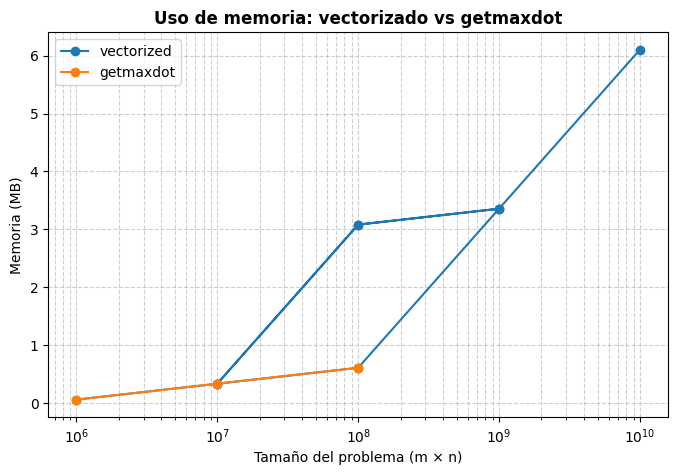

In [25]:
# Memoria
plt.figure(figsize=(8,5))
for method in df["method"].unique():
    subset = df[df["method"] == method]
    plt.plot(subset["problem_size"], subset["memory_MB"], marker="o", label=method)

plt.xscale("log")
plt.xlabel("Tamaño del problema (m × n)")
plt.ylabel("Memoria (MB)")
plt.title("Uso de memoria: vectorizado vs getmaxdot", fontweight='bold')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.show()

**Discusión de la gráfica: “Uso de memoria: vectorizado vs getmaxdot”**

- *Crecimiento de memoria en $getmaxdot$ (curva naranja)*: El consumo de memoria de $getmaxdot$ es muy bajo y crece lentamente con el tamaño del problema. Esto ocurre porque el algoritmo procesa cada producto escalar de manera independiente, sin necesidad de almacenar grandes estructuras intermedias. En consecuencia, incluso para tamaños grandes $(10^8–10^9)$, su consumo se mantiene por debajo de 1 MB.

- *Crecimiento de memoria en el método $vectorizado$ (curva azul)*: El método vectorizado utiliza mucha más memoria, sobre todo en los tamaños grandes $(10^9–10^{10})$. Esto se debe a que la operación Q.T @ X genera matrices intermedias de dimensiones $m \times n$, lo cual exige almacenar bloques grandes en memoria. Gracias al enfoque por bloques, este uso de memoria es limitado a unos pocos MB (en lugar de los cientos de GB que serían necesarios si se intentara calcular todo de una sola vez).

- *Comparación entre ambos métodos*: Mientras que $getmaxdot$ es muy eficiente en memoria, paga un precio muy alto en tiempo de ejecución. El $vectorizado$, aunque más costoso en memoria, logra tiempos mucho menores. En la práctica, este es un intercambio clásico entre tiempo y memoria:
$$\text{getmaxdot} → \text{menos memoria, mucho tiempo}$$
$$\text{vectorizado} → \text{más memoria, mucho menos tiempo}$$

- *Escalabilidad y limitaciones:* El $vectorizado$ comienza a mostrar un crecimiento pronunciado a partir de $10^8$, alcanzando valores de 6 MB en $10^{10}$. Aunque este valor es pequeño en términos absolutos, refleja el hecho de que para problemas aún más grandes, la estrategia por bloques es esencial para evitar desbordar la RAM.

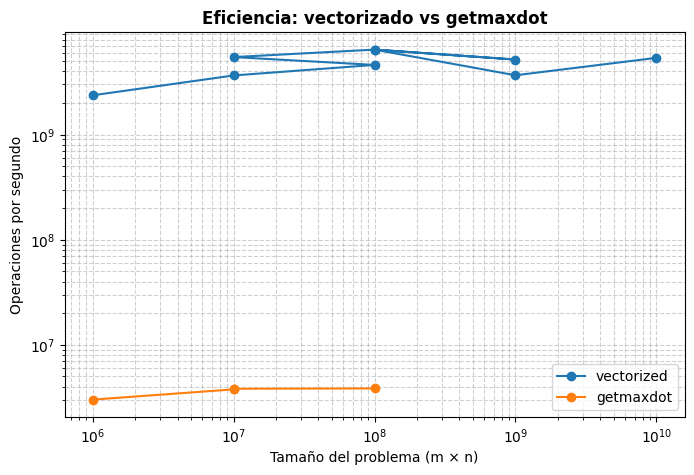

In [26]:
# Eficiencia (ops/sec)
plt.figure(figsize=(8,5))
for method in df["method"].unique():
    subset = df[df["method"] == method]
    plt.plot(subset["problem_size"], subset["ops_per_sec"], marker="o", label=method)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Tamaño del problema (m × n)")
plt.ylabel("Operaciones por segundo")
plt.title("Eficiencia: vectorizado vs getmaxdot", fontweight='bold')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.show()

**Discusión de la gráfica: “Eficiencia: vectorizado vs getmaxdot”**

- *Eficiencia del método $vectorizado$ (curva azul)*: Alcanza eficiencias del orden de $10^{10}$ operaciones por segundo. Esto muestra que aprovecha de manera óptima las rutinas de álgebra lineal optimizadas en NumPy, que están diseñadas para trabajar con operaciones masivas en paralelo. La curva se mantiene relativamente estable en valores altos a medida que crece el tamaño del problema, con ligeras variaciones debidas al manejo de memoria (bloques y caché). Esto significa que, incluso para tamaños grandes, el $vectorizado$ conserva un rendimiento casi constante y muy alto.

- *Eficiencia de $getmaxdot$ (curva naranja)*: Se mantiene en un nivel muy bajo, del orden de $10^6–10^7$ operaciones por segundo. Esto refleja su naturaleza pura e iterativa, sin vectorización ni paralelización. Además, la curva es prácticamente plana, indicando que el algoritmo no escala: a mayor tamaño del problema, sigue trabajando con la misma ineficiencia relativa.

- *Comparación entre ambos métodos:* La diferencia de eficiencia es muy evidente, ya que el $vectorizado$ supera a $getmaxdot$ en tres a cuatro órdenes de magnitud. En la práctica, esto significa que el $vectorizado$ puede resolver en segundos lo que $getmaxdot$ tardaría horas o días en procesar. Esta brecha se amplía conforme el tamaño del problema crece, reforzando la idea de que $getmaxdot$ no es útil para aplicaciones reales.

- *Escalabilidad y estabilidad:* El $vectorizado$ muestra un comportamiento muy escalable, se observa que conforme aumenta el tamaño del problema, mantiene un nivel casi constante de eficiencia. Esto sugiere que el método logra explotar la capacidad máxima de cómputo de la máquina hasta donde lo permiten los recursos de memoria. $Getmaxdot$, en cambio, no aprovecha mejor los recursos, quedando limitado por su diseño secuencial.

**Discusión de resultados experimentales**

* *¿Qué puedes concluir?*

Los experimentos muestran una diferencia clara entre los dos algoritmos:

El método $getmaxdot$ es simple y con bajo consumo de memoria, pero ineficiente en tiempo, incluso para tamaños moderados.

Por otra parte, el método $vectorizado$ aprovecha la optimización de librerías de álgebra lineal, alcanzando tiempos y eficiencias varios órdenes de magnitud mejores. Aunque requiere más memoria, gracias al procesamiento por bloques logra manejar problemas muy grandes.

Se puede decir que, en la práctica, solo el algoritmo $vectorizado$ es viable para aplicaciones reales a gran escala. (Ziogas et. al., 2021)

* *¿Qué costo es más significativo?*

Se observa que el tiempo de ejecución es el costo dominante:

El conteo de operaciones en ambos métodos es teóricamente similar $(O(mnd))$, pero la forma de implementarlas cambia drásticamente el desempeño.

En $getmaxdot$, la ejecución se vuelve prohibitiva a partir de $10^7–10^8$.

En el método $vectorizado$, el tiempo crece mucho más lentamente y se mantiene manejable incluso en $10^{10}$.

Por lo tanto, el tiempo real (y la eficiencia asociada) es el costo más crítico al decidir qué algoritmo usar.

* *Relación entre costo basado en conteo de operaciones y tiempo real*

Ambos algoritmos requieren aproximadamente el mismo número de operaciones aritméticas (sumas y productos). Sin embargo, el tiempo real no depende solo de la cantidad de operaciones, sino de cómo se ejecutan:

En $getmaxdot$, las operaciones se realizan en un bucle secuencial en Python $→$ baja eficiencia.

En $vectorizado$, las operaciones se delegan a rutinas optimizadas en C/Fortran con paralelización y SIMD $→$ altísima eficiencia. (Scientific Python Community, 2022)

Esto explica por qué el conteo de operaciones predice la complejidad teórica, pero no refleja el desempeño práctico si no se consideran optimizaciones de hardware y librerías.

* *Impacto de la memoria en cada algoritmo*

Método $getmaxdot$: muy bajo uso de memoria (procesa un vector a la vez). Es eficiente en este aspecto, pero sacrifica tiempo.

Método $vectorizado$: uso de memoria mayor, debido a matrices intermedias. Sin embargo, con el enfoque de bloques el crecimiento se mantiene controlado (en MB, no en GB).

Se puede concluir que la memoria impacta al $vectorizado$, pero no llega a ser un factor limitante en los experimentos. En cambio, para $getmaxdot$ el problema no es la memoria, sino el tiempo.

* *¿Cómo podríamos crear un mejor algoritmo?*

1. Bloques adaptativos: ya implementado, pero podría ajustarse dinámicamente según el tamaño de caché y RAM disponibles.

2. Aproximación en lugar de exactitud: en problemas de búsqueda top-k, se pueden usar algoritmos aproximados (ej. Locality Sensitive Hashing, Product Quantization) que reducen drásticamente tiempo y memoria sacrificando algo de exactitud (Jégou et.al., 2011).

3. Paralelización explícita: aprovechar GPU o librerías multihilo (ej. CuBLAS en CUDA o PyTorch) para acelerar aún más el vectorizado (Torres et.al., 2024).

4. Estructuras de datos especializadas: usar índices (árboles de búsqueda, k-d trees, HNSW graphs) en lugar de comparar contra todas las columnas de X (Samet et.al., 2006).

**Conclusión general**

El análisis confirma que la vectorización es la clave para resolver el problema top-1 de manera eficiente. El tiempo de ejecución es el costo más importante a considerar, mucho más que la memoria. Aunque ambos algoritmos tienen la misma complejidad teórica, en la práctica la eficiencia de las operaciones vectorizadas marca una diferencia de varios órdenes de magnitud. Para problemas aún más grandes, un mejor algoritmo debería combinar procesamiento por bloques, paralelización y, cuando sea aceptable, aproximaciones que reduzcan el número de operaciones exactas.

**Referencias**

- Jégou, H., Douze, M., & Schmid, C. (2011). Product quantization for nearest neighbor search. IEEE Transactions on Pattern Analysis and Machine Intelligence, 33(1), 117–128.
- Malkov, Y. A., & Yashunin, D. A. (2020). Efficient and robust approximate nearest neighbor search using Hierarchical Navigable Small World graphs. IEEE Transactions on Pattern Analysis and Machine Intelligence, 42(4), 824–836.
- Samet, H. (2006). Foundations of multidimensional and metric data structures (2nd ed.). Morgan Kaufmann.
- Scientific Python Community. (2022). NumPy C function implementations. Discuss.scientific-python.org. https://discuss.scientific-python.org/t/numpy-c-function-implementations/1616
- Torres, L. A., Barrios H., C. J., & Denneulin, Y. (2024). Evaluation of computational and energy performance in matrix multiplication algorithms on CPU and GPU using MKL, cuBLAS and SYCL.
- Ziogas, A. N., Ben-Nun, T., Schneider, T., & Hoefler, T. (2021). NPBench: A Benchmarking Suite for High-Performance NumPy. En Proceedings of the 2021 International Conference on Supercomputing (ICS '21). ACM.
